<a href="https://colab.research.google.com/github/searcherm1/SV_Learning_Project/blob/master/Skillbox_1_Startups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Описание:
<br>Вам предстоит работать с табличными данными, в которых представлена информация о стартапах, которые функционировали в период с 1980 по 2018 годы. Вам нужно предсказать, какие из них закроются, а какие нет. Соревнование проводится на популярной платформе Kaggle, что позволит вам не только применять на практике свои знания в области анализа данных и машинного обучения, но и освоить работу с этой платформой. Срок проведения соревнования составляет 2 недели.

Цель проекта:
<br>Разработать модель машинного обучения для предсказания продолжения деятельности стартапа.
Провести полноценный разведочный анализ и сформировать рекомендации будущим создателям стартапов (какие факторы влияют на успешность стартапа).
<br> Целвая метрика - F1 score


In [1]:
! pip install phik -q
! pip install shap -q
! pip install Unidecode -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 4.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.preprocessing import (
                                    StandardScaler,
                                    MinMaxScaler,
                                    OneHotEncoder,
                                    OrdinalEncoder,
                                    LabelEncoder
                                   )
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import phik
from unidecode import unidecode
plt.rcParams['font.size'] = 10.0
plt.rcParams.update({'axes.titlesize': 'large'})
sns.set_context(
                'notebook',
                rc={
                    'font.size': 10,
                    'axes.titlesize': 10,
                    'xtick.labelsize': 'small',
                    'ytick.labelsize': 'small',
                    'legend.fontsize': 'small',
                    'legend.title_fontsize': 10
                }
            )
RANDOM_STATE = 50

In [3]:
data_train = pd.read_csv('/content/drive/MyDrive/M1_kaggle_data/kaggle_startups_train_28062024.csv', sep=',')
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN


In [4]:
data_train.shape

(52516, 13)

Итак, у нас 52516 строк (записей) по 13 признаков.

In [5]:
data_test = pd.read_csv('/content/drive/MyDrive/M1_kaggle_data/kaggle_startups_test_28062024.csv', sep=',')
data_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209


In [6]:
data_test.shape

(13125, 11)

Выводим колонки из тестового датасета, которых нет в учебном датасете:

In [7]:
for col in data_test.columns:
    if col not in data_train.columns:
        print(f'Колонка тестового датасета {col} отсутствет в обучающем датасете')

Колонка тестового датасета lifetime отсутствет в обучающем датасете


In [8]:
for col in data_train.columns:
    if col not in data_test.columns and col!='status': #убераю колонку целевого признака
        print(f'Колонка обучающего датасета {col} отсутствет в тестовом датасете')

Колонка обучающего датасета founded_at отсутствет в тестовом датасете
Колонка обучающего датасета closed_at отсутствет в тестовом датасете


По результатам загрузки датасетов обнаружено следующее:
* в обучающем датастет отсутствует признак lifetime ();
* в тестовом датасете отсутствуют признаки founded_at и closed_at.

#Предобработка данных

## Обучающий датасет

Ввод количества пропусков для каждого признака

In [9]:
data_train.isna().sum()

,0
name,1
category_list,2465
funding_total_usd,10069
status,0
country_code,5502
state_code,6763
region,6359
city,6359
funding_rounds,0
founded_at,0


Пройдемся по уникальным значениям категориальных признаков для анализа принимаемых значений

In [10]:
data_train.status.unique()

array(['operating', 'closed'], dtype=object)

Полагая, что пропуски closed_at появились из-за того, что стартап не закрылся к 2018 году, посчитаю количество пропусков в столбце 'closed_at' стартапов со статусом 'closed':

In [11]:
cond = data_train['status']=='closed'
data_train.loc[cond,'closed_at'].isna().sum()

0

Таким образом колонка closed_at является "утечкой" целевого признака status. <br>Ведь дата закрытия не важна, поскольку строится модель бинарной классификации, а не регрессии для оценки сколько протянет стартап.
<br>Следовательно, от колонки 'closed at' можно избавиться, но зная дату закрытия можно посчитать отсутствующий признак lifetime.

In [12]:
data_train['closed_at'] = data_train['closed_at'].fillna('2018-01-01')

In [13]:
data_train.dtypes

,0
name,object
category_list,object
funding_total_usd,float64
status,object
country_code,object
state_code,object
region,object
city,object
funding_rounds,int64
founded_at,object


Перевожу данные обучающего датасета в столбцах с датами в формат datetime:

In [14]:
date_col = ['founded_at','closed_at', 'first_funding_at', 'last_funding_at']
for col in date_col:
    data_train[col] = pd.to_datetime(data_train[col], format='%Y-%m-%d')
data_train.dtypes

,0
name,object
category_list,object
funding_total_usd,float64
status,object
country_code,object
state_code,object
region,object
city,object
funding_rounds,int64
founded_at,datetime64[ns]


In [15]:
data_train['lifetime'] = (data_train['closed_at']-data_train['founded_at']).dt.days
data_train.head(10)

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,2018-01-01,2998
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,2018-01-01,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,2018-01-01,4383
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,2018-01-01,5114
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,2018-01-01,2791
5,Connected Sports Ventures,Mobile,4300000.0,operating,USA,NJ,Newark,Princeton,1,2011-04-16,2012-11-12,2012-11-12,2018-01-01,2452
6,Attensity,Analytics|Business Analytics|Social CRM|Social...,90000000.0,operating,USA,CA,SF Bay Area,Redwood City,1,2000-01-01,2014-05-14,2014-05-14,2018-01-01,6575
7,Mesh Networks,Software,4300000.0,operating,USA,TX,Houston,Houston,1,2005-01-01,2014-11-09,2014-11-09,2018-01-01,4748
8,AngioScore,Biotechnology,42000000.0,operating,USA,CA,SF Bay Area,Fremont,2,2003-01-01,2007-10-09,2011-04-20,2018-01-01,5479
9,Vidatronic,Semiconductors,1250500.0,operating,USA,TX,Austin,College Station,2,2010-01-01,2011-08-23,2013-03-21,2018-01-01,2922


In [16]:
data_train = data_train.drop(['founded_at', 'closed_at'], axis=1)
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,2998
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2010-05-04,2014-02-25,4748
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2012-08-20,2014-07-02,4383
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2011-09-01,2014-07-18,5114
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2012-02-01,2012-02-01,2791


Имя стартапа - это уникальный признак, но он, как и имя человека, не влияет на его успешность. Пропуск заполнять не буду, поскольку признак будет удален. Однако по имени можно заполнить пропуски в колонке country code, region и city.

Заполняю пропуски в столбце 'category_list' для последующей обработки.

In [17]:
data_train['category_list'] = data_train['category_list'].fillna('Unknown')
data_train['category_list'].isna().sum()

0

In [18]:
len(data_train['category_list'].unique())

22106

Для удобства работы выведу уникальные значеиня признака 'category_list', завернутые в список:

In [19]:
uniq_cat_list = list(data_train['category_list'].unique())
uniq_cat_list #смотрим, что получается

['Online Reservations|Restaurants',
 'Manufacturing|Medical|Medical Devices',
 'Biotechnology',
 'Health Care',
 'Manufacturing',
 'Mobile',
 'Analytics|Business Analytics|Social CRM|Social Media Monitoring|Software',
 'Software',
 'Semiconductors',
 'Clean Technology',
 'Unknown',
 'Nanotechnology|Technology|Wine And Spirits',
 'Customer Service|Delivery|Retail',
 'Analytics|Cloud Data Services|Computers|Networking|Software',
 'Banking|Finance|Loyalty Programs',
 'Messaging',
 'Consumers',
 'Generation Y-Z|Photo Sharing|Social Media',
 'College Recruiting|Enterprise Software|Recruiting|SaaS|Social Recruiting|Software',
 'Technology',
 'Finance|Financial Services|Payments',
 'Cloud Computing|Enterprise Resource Planning|Manufacturing|Software',
 'DIY|Environmental Innovation',
 'Entertainment|Games',
 'Internet|Pets|Services',
 'Advertising|Sales and Marketing',
 'Fitness|Sports',
 'Consumer Goods|Food Processing|Organic Food',
 'Analytics|Big Data|Business Intelligence|Marketplaces',


Уникальные категории содержат в себе неявные дубликаты, но самое главное стартап может заниматься разработкой продукта из нескольких сфер деятельности.
<br> Таким образом есть необходимость создать новый признак с указанием сферы деятельности, в которой работает стартап.
<br> Поскольку есть стартапы, работающие в нескольких сферах, то будет введен ещё один признак - количество сфер деятельности стартапа.

Для выделения сфер деятельности в первом приближении посчитаю, а сколько раз встречаются слова и словосочетания в собранном выше списке инкальных значений признаков столбца 'category_list'.
Для этого создаю список, в котором каждое словосочетание будет отдельным элементом и пропущу этот список через класс Counter из модуля collections

In [20]:
# создаю пустой список со всеми категориями
all_cats = []
for w in uniq_cat_list:
    # наполняю список всеми категориями
    all_cats.extend(w.split('|'))
#проверяю, что все отработало как надо
all_cats

['Online Reservations',
 'Restaurants',
 'Manufacturing',
 'Medical',
 'Medical Devices',
 'Biotechnology',
 'Health Care',
 'Manufacturing',
 'Mobile',
 'Analytics',
 'Business Analytics',
 'Social CRM',
 'Social Media Monitoring',
 'Software',
 'Software',
 'Semiconductors',
 'Clean Technology',
 'Unknown',
 'Nanotechnology',
 'Technology',
 'Wine And Spirits',
 'Customer Service',
 'Delivery',
 'Retail',
 'Analytics',
 'Cloud Data Services',
 'Computers',
 'Networking',
 'Software',
 'Banking',
 'Finance',
 'Loyalty Programs',
 'Messaging',
 'Consumers',
 'Generation Y-Z',
 'Photo Sharing',
 'Social Media',
 'College Recruiting',
 'Enterprise Software',
 'Recruiting',
 'SaaS',
 'Social Recruiting',
 'Software',
 'Technology',
 'Finance',
 'Financial Services',
 'Payments',
 'Cloud Computing',
 'Enterprise Resource Planning',
 'Manufacturing',
 'Software',
 'DIY',
 'Environmental Innovation',
 'Entertainment',
 'Games',
 'Internet',
 'Pets',
 'Services',
 'Advertising',
 'Sales and M

Провожу расчет количества повторов словосочетаний.

In [21]:
Counters_found = Counter(all_cats)
most_occur = Counters_found.most_common(len(all_cats))
print(most_occur)

[('Software', 3089), ('Mobile', 3031), ('E-Commerce', 1849), ('Social Media', 1769), ('SaaS', 1463), ('Enterprise Software', 1364), ('Curated Web', 1353), ('Internet', 1341), ('Advertising', 1254), ('Apps', 1172), ('Analytics', 1116), ('Technology', 1064), ('Services', 896), ('Games', 826), ('Education', 805), ('Marketplaces', 798), ('Finance', 785), ('Video', 735), ('Big Data', 697), ('Cloud Computing', 695), ('Health Care', 668), ('Health and Wellness', 666), ('Sales and Marketing', 600), ('Social Network Media', 585), ('Startups', 573), ('Networking', 535), ('Media', 524), ('Search', 520), ('Entertainment', 517), ('Retail', 512), ('Information Technology', 497), ('Design', 482), ('Security', 479), ('Travel', 475), ('Music', 472), ('Fashion', 454), ('Digital Media', 449), ('Sports', 441), ('Android', 438), ('Web Development', 419), ('Financial Services', 418), ('Manufacturing', 413), ('FinTech', 409), ('Medical', 407), ('iPhone', 399), ('Content', 390), ('Events', 383), ('Hardware + 

 Для удобства анализа создаю датафрейм и построю столбчатую диаграмму.

In [22]:
com_cats_df = pd.DataFrame(most_occur, columns=['category', 'count'])
com_cats_df.head(50)

,category,count
0,Software,3089
1,Mobile,3031
2,E-Commerce,1849
3,Social Media,1769
4,SaaS,1463
5,Enterprise Software,1364
6,Curated Web,1353
7,Internet,1341
8,Advertising,1254
9,Apps,1172


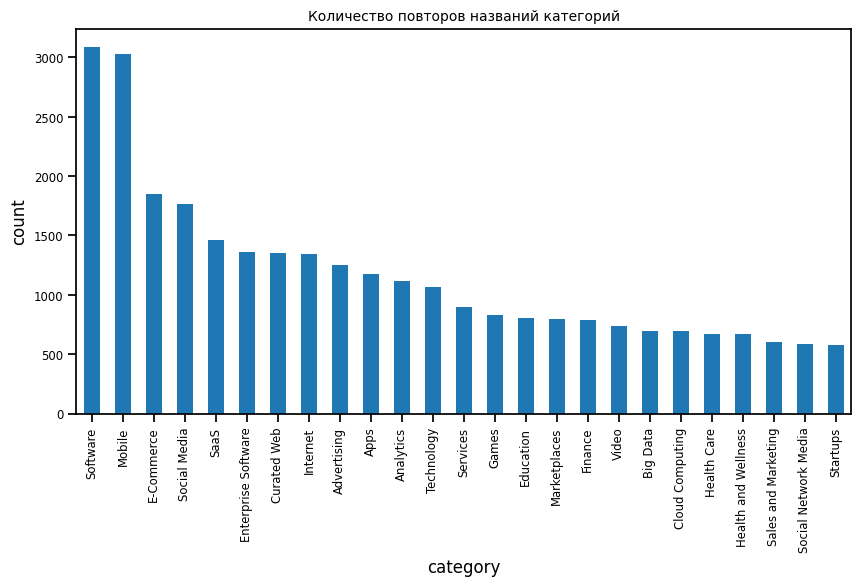

In [23]:
com_cats_df[:25].plot(kind='bar',
                      figsize=(10, 5),
                      x = 'category',
                      xlabel='category',
                      ylabel='count',
                      legend=False,
                      title='Количество повторов названий категорий'
                     );

Как видно, самые четкие категории это:
* Sofware
* Mobile
* E-Commerce
* Social Media/Media
* Interent
* Advertising
* Analytics
* Education
<br>Но сохраняются неявные дубликаты. Если их убрать и сгруппировать снова, то будут видны ещё одни варианты категорий, которые имеют меньшее количество повторов в созданном датафрейме с расчетом повторяемости словосочетаний.  

Посмотрим, что останется если сгруппировать по понятным общим категориям сферы деятельности и убрать уже выделенные для рассмотрения:


In [24]:
cond = ~(
            (com_cats_df['category'].str.contains('Software')) |
            (com_cats_df['category'].str.contains('Mobile')) |
            (com_cats_df['category'].str.contains('Media')) |
            (com_cats_df['category'].str.contains('Web')) |
            (com_cats_df['category'].str.contains('Internet')) |
            (com_cats_df['category'].str.contains('Marketing')) |
            (com_cats_df['category'].str.contains('Health')) |
            (com_cats_df['category'].str.contains('Data')) |
            (com_cats_df['category'].str.contains('Fin')) |
            (com_cats_df['category'].str.contains('Consult'))
        )
com_cats_df[cond]

,category,count
2,E-Commerce,1849
4,SaaS,1463
8,Advertising,1254
9,Apps,1172
10,Analytics,1116
...,...,...
850,Baby Boomers,1
851,Mothers,1
852,TV Station,1
853,Invention,1


Таким образом явно выделяются следующие сферы:
* Software, куда войдет и SaaS, Apps;
* Mobile;
* Media;
* Internet & Web, куда войдет все что связано с Online, Web Design, Cloud;
* Sales & Marketing;
* Finance;
* Advertising;
* E-Commerce;
* Health, куда войдет все, что связано с медициной;
* Data Analytics, куда войдет AI, ML, анализ данных;
* Entertainment, куда войдут Video, Games, Travel
* Consulting
* Location Based Services, куда входят Maps, GPS


Создаю новый признак 'categorie_filed', который описывает сферу продукта стартапа. Создание идет путем обощения/группировки описаний 'category_list' по ключевым словам, присущим сфере.
<br> Создан словарь, где ключом является сфера, а занчением - список, элементы которого есть признаковые описания сферы деятеьлности.


In [25]:
sphere_dict = {
                'Software' : ['Software', 'SaaS'],
                'Mobile' : ['Mobile', 'iOS', 'Android', 'Apps'],
                'Media' : ['News', 'Media', 'Broadcast'],
                'IT' : ['Information Technology', 'IT', 'Computer', 'Interface'], # будет как более общая категория, в которую не входит Software
                'Internet & Web Services' : ['Web', 'Internet', 'Blog', 'Online'],
                'Sales & Marketing' : ['Sales', 'Marketing', 'Purchase'],
                'Finance' : ['Banking', 'Fin', 'Payments', 'Capital', 'Accounting'],
                'Advertising': ['Advert'],
                'E-Commerce' : ['E-Commerce', 'B2B', 'B2C', 'B2E', 'B2G', 'B2O', 'C2A', 'C2B', 'C2C', 'A2A', 'A2B', 'A2C', 'D2C', 'G2B', 'P2P'],
                'Health' : ['Health', 'Medic', 'Fitness'],
                'AI & Data' : ['AI', 'Artificial Intelligence', 'Machine Learning', 'NLP', 'ML', 'Neural', 'Image Recognition', 'Computer Vision', 'Data'],
                'Entertainment' : ['Entertainment', 'Game', 'Movie', 'Film', 'Show', 'Lottery', 'Music', 'Art', 'Travel', 'Photography'],
                'Education': ['Education', 'Training'],
                'HR' : ['Human Resources', 'Recruit', 'Staff', 'Employment'],
                'Retail' : ['Shop', 'Marketplace', 'Retail'],
                'Sports' : ['Sport', 'Gamble'],
                'Pharm' : ['Pharm'],
                'Business' : ['Business'],
                'Security' : ['Security'],
                'Natural Resourses' : ['Oil', 'Gas', 'Solar', 'Energy'],
                'Real Estate': ['Estate'],
                'Mining': ['Mine', 'Bitcoin'],
                'Bio' : ['Bio'],
                'Politics' : ['Politics'],
                'Consulting' : ['Consult'],
                'LBS' : ['LBS', 'Location Based', 'GPS'],
                'Manufacturing' : ['Manufact', 'Production'],
                'Food & Drinks' : ['Food', 'Restaurants', 'Drink', 'Wine'],
                }

### Добавление категории со сферой деятельности

Теперь осталось дополнить словарь категориями, состоящими из одного или двух слов.

In [26]:
def field_cat(row):
    cat_val = 'Unclassified'
    for cat in sphere_dict:
        for elm in sphere_dict[cat]:
            if elm in row:
                cat_val = cat
                break
        if cat_val != 'Unclassified':
            break
    #добавляю оставшиеся категории, которые не удалось обобщить.
    if cat_val == 'Unclassified':
        cat_val = row
    return cat_val

Создаю столбец с категориями сферы деятельности

In [27]:
data_train['cat_field'] = data_train['category_list'].apply(field_cat)
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,cat_field
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,2998,Internet & Web Services
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2010-05-04,2014-02-25,4748,Health
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2012-08-20,2014-07-02,4383,Bio
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2011-09-01,2014-07-18,5114,Health
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2012-02-01,2012-02-01,2791,Manufacturing


### Добавление категории с количеством сфер деятельности

Теперь создаю признак с количествами сфер, в которых работал или работает стартап.
<br>Расчет количества сфер деятельности производится в функции num_of_cats.

In [28]:
def num_of_cats(row):
    counter = 0 #счетчик
    cat_val = 'Unclassified'
    for cat in sphere_dict:
        for elm in sphere_dict[cat]:
            # условие совпадения сферы
            if elm in row:
                cat_val = cat
                counter += 1
                break
    if cat_val == 'Unclassified':
        counter = 1
    return counter

Создаю признак количества категорий и проверяю как он отработал.

In [29]:
data_train['cat_field_#'] = data_train['category_list'].apply(num_of_cats)
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,cat_field,cat_field_#
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,2998,Internet & Web Services,2
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2010-05-04,2014-02-25,4748,Health,2
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2012-08-20,2014-07-02,4383,Bio,1
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2011-09-01,2014-07-18,5114,Health,1
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2012-02-01,2012-02-01,2791,Manufacturing,1


Заполню пропуск в столбце 'funding_total_usd' минимальным значением.

In [30]:
data_train['funding_total_usd'] = data_train['funding_total_usd'].fillna(data_train['funding_total_usd'].min())
data_train.loc[10:20]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,cat_field,cat_field_#
10,Indie Vinos,Software,1.000000e+00,operating,USA,OR,"Portland, Oregon",Portland,1,2013-04-21,2013-04-21,3287,Software,1
11,Seven Seas Water,Clean Technology,2.000000e+07,operating,USA,FL,Tampa,Tampa,1,2008-02-04,2008-02-04,7670,Clean Technology,1
12,Iberic Premium,Unknown,1.072390e+05,closed,NaN,NaN,NaN,NaN,1,2014-06-01,2014-06-01,714,Unknown,1
13,BuildersCloud,Software,1.100000e+06,operating,USA,WA,Seattle,Bellevue,1,2013-08-08,2013-08-08,2192,Software,1
14,Purewine,Nanotechnology|Technology|Wine And Spirits,3.350000e+05,operating,NaN,NaN,NaN,NaN,2,2014-08-28,2015-08-05,1461,Food & Drinks,1
15,paack,Customer Service|Delivery|Retail,3.000000e+04,operating,NaN,NaN,NaN,NaN,1,2015-02-01,2015-02-01,1731,Retail,1
16,Salesjob,Unknown,1.000000e+00,closed,NaN,NaN,NaN,NaN,1,2013-10-22,2013-10-22,952,Unknown,1
17,Avi Networks Inc,Analytics|Cloud Data Services|Computers|Networ...,3.300000e+07,operating,USA,CA,SF Bay Area,Sunnyvale,2,2012-11-01,2014-08-01,2192,Software,3
18,The Glassbox,Software,4.250000e+05,operating,USA,NY,New York City,New York,1,2013-11-27,2013-11-27,2922,Software,1
19,Cipher Surgical,Health Care,4.475451e+06,operating,GBR,C7,Coventry,Coventry,5,2011-04-22,2015-04-01,3139,Health,1


### Добавление признака количества дней между первой и последней датами финансирования

Введу признак количества дней между первой и последней датами финансирования:

In [31]:
data_train['funding_days_delta'] = (data_train['last_funding_at'] \
                                    - data_train['first_funding_at']).apply(lambda x: x.days)
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,cat_field,cat_field_#,funding_days_delta
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,2998,Internet & Web Services,2,1310
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2010-05-04,2014-02-25,4748,Health,2,1393
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2012-08-20,2014-07-02,4383,Bio,1,681
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2011-09-01,2014-07-18,5114,Health,1,1051
4,WireTough Cylinders,Manufacturing,1.0,operating,USA,VA,VA - Other,Bristol,1,2012-02-01,2012-02-01,2791,Manufacturing,1,0


In [32]:
cond = ~(data_train['country_code'].isna()) & (data_train['city'].isna())
data_train[cond].head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,cat_field,cat_field_#,funding_days_delta
50,Tripalocal,Travel,850000.0,operating,AUS,NaN,NaN,NaN,1,2015-06-01,2015-06-01,1461,Entertainment,1,0
105,Amp'd Mobile,Mobile,374000000.0,closed,USA,NaN,NaN,NaN,4,2005-08-08,2007-03-21,1972,Mobile,1,590
324,Cloud Health Care,Application Platforms|mHealth|Tracking,50000.0,closed,RUS,NaN,NaN,NaN,1,2012-02-01,2012-02-01,728,Health,1,0
338,NeRRe Therapeutics,Fitness|Health Care|Medical,18400000.0,operating,GBR,F7,NaN,NaN,1,2012-12-19,2012-12-19,2192,Health,1,0
344,Meiaoju,Curated Web,8130000.0,operating,CHN,NaN,NaN,NaN,1,2014-03-23,2014-03-23,1372,Internet & Web Services,1,0


In [33]:
columns = ['country_code', 'state_code', 'region', 'city']
for c in columns:
    data_train[c] = data_train[c].fillna('Undefined')
data_train.head()
data_train.loc[200:206]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,cat_field,cat_field_#,funding_days_delta
200,ClipCall,Android|Apps|Bridging Online and Offline|Home ...,1.0,closed,USA,CA,SF Bay Area,Palo Alto,1,2015-09-15,2015-09-15,918,Mobile,4,0
201,Dana-Farber Cancer Institute,Health and Wellness,10000000.0,operating,USA,MA,Boston,Boston,1,2012-01-31,2012-01-31,2875,Health,1,0
202,DFR Asia,Angels|Digital Media|Entertainment|Finance|Mus...,1.0,closed,CHN,23,Shanghai,Shanghai,1,2015-06-13,2015-06-13,3598,Media,3,0
203,Vidible,Advertising Exchanges|Video,4450673.0,operating,USA,CA,SF Bay Area,San Francisco,2,2013-11-20,2014-01-03,2010,Advertising,1,44
204,Ash Access Technology,Biotechnology,453000.0,operating,USA,IN,IN - Other,Lafayette,3,2004-01-01,2010-06-04,5477,Bio,1,2346
205,ScalIT,Enterprise Software,30000.0,operating,USA,CT,Hartford,West Hartford,1,2013-11-18,2013-11-18,2192,Software,1,0
206,PSC Info Group,Unknown,1.0,operating,USA,PA,Philadelphia,Oaks,1,2002-07-31,2002-07-31,6121,Unknown,1,0


Заполняю пропуски в 'country_code' значением 'Undefined'. Затем для стартапов у которых код страны указан, но отсутствует 'state_code' заполняю его самым часто встречающимся.

### Работа с признаками локации стартапов

Заполняю пропуски в столбце 'state_code	' модой страны, если она указана:

In [34]:
def state_code_fill(row, df):
    if (row['country_code'] != 'Undefined') and (row['state_code'] == 'Undefined'):
        #print(type(row['state_code']))
        cond = (df['country_code'] == row['country_code'])
        state_code = df[cond]['state_code'].mode()[0]
    else:
        state_code = row['state_code']
    return state_code

In [35]:
data_train['state_code'] = data_train.apply(lambda row: state_code_fill(row, data_train), axis=1)
data_train['state_code'].isna().sum()

0

Заполняю пропуск с регионом страны самым частовстречающимся значением:

In [36]:
def region_fill(row, df):
    if (row['state_code'] != 'Undefined') and (row['region'] == 'Undefined'):
        cond = (df['country_code'] == row['country_code']) & (df['state_code'] == row['state_code'])
        region = df[cond]['region'].mode()[0]
    else:
        region = row['region']
    return region

In [37]:
data_train['region'] = data_train.apply(lambda row: region_fill(row, data_train), axis=1)
data_train['region'].isna().sum()

0

In [38]:
def city_fill(row, df):
    if (row['state_code'] != 'Undefined') and (row['city'] == 'Undefined'):
        cond = (df['country_code'] == row['country_code']) & (df['state_code'] == row['state_code'])
        city = df[cond]['city'].mode()[0]
    else:
        city = row['city']
    return city

In [39]:
data_train['city'] = data_train.apply(lambda row: city_fill(row, data_train), axis=1)
data_train.loc[[50, 105, 324, 344]]

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,cat_field,cat_field_#,funding_days_delta
50,Tripalocal,Travel,850000.0,operating,AUS,2,Sydney,Sydney,1,2015-06-01,2015-06-01,1461,Entertainment,1,0
105,Amp'd Mobile,Mobile,374000000.0,closed,USA,CA,SF Bay Area,San Francisco,4,2005-08-08,2007-03-21,1972,Mobile,1,590
324,Cloud Health Care,Application Platforms|mHealth|Tracking,50000.0,closed,RUS,48,Moscow,Moscow,1,2012-02-01,2012-02-01,728,Health,1,0
344,Meiaoju,Curated Web,8130000.0,operating,CHN,22,Beijing,Beijing,1,2014-03-23,2014-03-23,1372,Internet & Web Services,1,0


Создаю признаки 'lattitude' и 'longitude', взяв координаты из датасета.
<br> Загружаю датасет.

In [40]:
df_coord = pd.read_csv('/content/drive/MyDrive/worldcities.csv', sep=',', low_memory=False)
df_coord.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37732000.0,1392685764
1,Jakarta,Jakarta,-6.1750,106.8275,Indonesia,ID,IDN,Jakarta,primary,33756000.0,1360771077
2,Delhi,Delhi,28.6100,77.2300,India,IN,IND,Delhi,admin,32226000.0,1356872604
3,Guangzhou,Guangzhou,23.1300,113.2600,China,CN,CHN,Guangdong,admin,26940000.0,1156237133
4,Mumbai,Mumbai,19.0761,72.8775,India,IN,IND,Mahārāshtra,admin,24973000.0,1356226629


In [41]:
df_coord.isna().sum()

,0
city,0
city_ascii,1
lat,0
lng,0
country,0
iso2,33
iso3,0
admin_name,197
capital,34845
population,212


Проверяю что есть по городу Москва:

In [42]:
cond = (df_coord['city'].str.contains('Moscow'))
df_coord[cond]

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
17,Moscow,Moscow,55.7558,37.6172,Russia,RU,RUS,Moskva,primary,17332000.0,1643318494
20136,Moscow,Moscow,46.7308,-116.9986,United States,US,USA,Idaho,NaN,25616.0,1840019868


In [43]:
def coord_extraction(row):
    if row['country_code'] != 'Undefined':
        cond = (df_coord['iso3'] == row['country_code']) \
            & (df_coord['city'].str.contains(row['city']))
        if len(df_coord[cond]) > 0:
            latit = df_coord[cond]['lat'].values[0]
            longit = df_coord[cond]['lng'].values[0]
        else: #есть полное указание населенного пункта, но нет для него координат
            latit = 0
            longit = 0
    else:
        latit = 0
        longit = 0
    return latit, longit

Тестирую работу функции по указанию координат

In [44]:
df_test = data_train[:4].copy()
df_test[['latit', 'longit']] = df_test.apply(coord_extraction, axis=1, result_type='expand')
df_test.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,cat_field,cat_field_#,funding_days_delta,latit,longit
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,2998,Internet & Web Services,2,1310,47.3744,8.5411
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2010-05-04,2014-02-25,4748,Health,2,1393,37.5025,-122.2253
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2012-08-20,2014-07-02,4383,Bio,1,681,37.3012,-121.8480
3,Sancilio and Company,Health Care,22250000.0,operating,Undefined,Undefined,Undefined,Undefined,3,2011-09-01,2014-07-18,5114,Health,1,1051,0.0000,0.0000


Тестирование прошло успешно, функция работает. Применяю её ко всему датасету:

In [45]:
data_train[['latit', 'longit']] = data_train.apply(coord_extraction, axis=1, result_type='expand')
data_train.head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,cat_field,cat_field_#,funding_days_delta,latit,longit
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,2998,Internet & Web Services,2,1310,47.3744,8.5411
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2010-05-04,2014-02-25,4748,Health,2,1393,37.5025,-122.2253
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2012-08-20,2014-07-02,4383,Bio,1,681,37.3012,-121.8480
3,Sancilio and Company,Health Care,22250000.0,operating,Undefined,Undefined,Undefined,Undefined,3,2011-09-01,2014-07-18,5114,Health,1,1051,0.0000,0.0000
4,WireTough Cylinders,Manufacturing,1.0,operating,USA,VA,VA - Other,Bristol,1,2012-02-01,2012-02-01,2791,Manufacturing,1,0,36.5572,-82.2154


Посчитаю количество стартапов, для которых не удалось определить координаты геолокации городов:

In [46]:
cond = data_train['latit'] == 0
print('Число стартапов без геометки:', len(data_train[cond]))
print(f'Доля таких записей составляет: {len(data_train[cond])/len(data_train):0.2%}')

Число стартапов без геометки: 9356
Доля таких записей составляет: 17.82%


Удаляю признаки, которые были не будут использованы в модели:

In [47]:
y = data_train['status']
X = data_train.drop(['name','category_list', 'country_code', 'state_code', 'region', 'city', 'last_funding_at', 'first_funding_at', 'status'], axis=1)

## Матрица Phik для обучающего датасета

/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable cat_field is large: 1884. Are you sure this is not an interval variable? Analysis for pairs of variables including cat_field can be slow.
  warnings.warn(


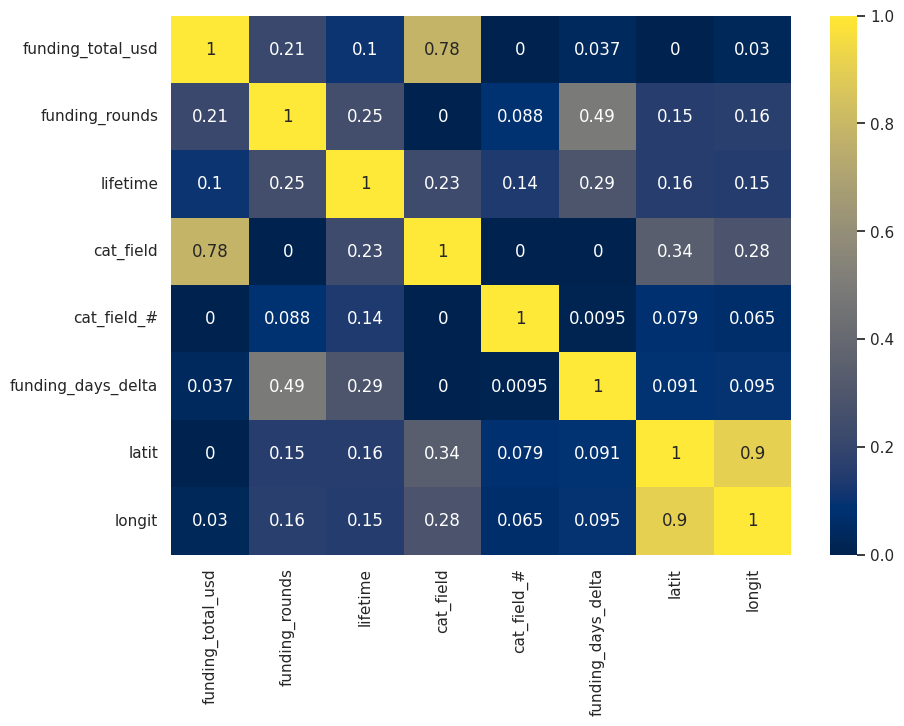

In [48]:
sns.set_theme(rc={'figure.figsize':(10, 7)})
sns.heatmap(
            X.phik_matrix(interval_cols=['funding_total_usd', 'funding_rounds', 'lifetime', 'cat_field_#', 'funding_days_delta', 'latit', 'longit']),
            annot=True,
            cmap='cividis'
            );

Мультиколлинеарность имеется в широте и долготе.

In [49]:
X.head()

,funding_total_usd,funding_rounds,lifetime,cat_field,cat_field_#,funding_days_delta,latit,longit
0,828626.0,2,2998,Internet & Web Services,2,1310,47.3744,8.5411
1,42935019.0,4,4748,Health,2,1393,37.5025,-122.2253
2,35456381.0,3,4383,Bio,1,681,37.3012,-121.8480
3,22250000.0,3,5114,Health,1,1051,0.0000,0.0000
4,1.0,1,2791,Manufacturing,1,0,36.5572,-82.2154


Создаю списки с названиями кололнок базируясь на их типе данных. Для категориальных признаков получается только одна колонка, для числовых признаков - несколько.

In [50]:
ohe_col = ['cat_field']
num_col = ['funding_total_usd',	'funding_rounds', 'lifetime', 'cat_field_#', 'funding_days_delta', 'latit', 'longit']

## Создание пайплайнов

In [51]:
data_preproc = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ohe_col),
        ('num', StandardScaler(), num_col),
    ],
    remainder='passthrough'
)

In [52]:
fin_pipe = Pipeline(
    [
        ('preproc', data_preproc),
        ('models', LogisticRegression())
    ]
)

In [53]:
param_distr = [
    {
        'models': [LogisticRegression(
            random_state = RANDOM_STATE,
            penalty='l1',
            solver = 'saga'
            )],
        'models__C': range(1, 5),
        'preproc__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [DecisionTreeClassifier(random_state = RANDOM_STATE)],
        'models__max_depth': range(2, 50),
        'preproc__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [SVC(
            random_state = RANDOM_STATE,
            kernel='rbf'
            )],
        'models__gamma': [0.01, 0.1, 1, 5, 10],
        'preproc__num': [StandardScaler(), MinMaxScaler()]
    }
]

Для поиска модели с оптимальными гиперпараметрами использую RandomizedSearchCV.

In [54]:
rand_srch = RandomizedSearchCV(
    fin_pipe,
    param_distr,
    cv = 5,
    scoring='f1',
    random_state = RANDOM_STATE,
    n_jobs=-1,
)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.25,
    random_state=RANDOM_STATE
)

In [56]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test_pure = y_test
y_test = label_encoder.transform(y_test)

Визуализирую как закодировался целевой признак:

In [57]:
pd.DataFrame(zip(y_test_pure, y_test), columns=['до кодирования', 'после кодирования']).head()

,до кодирования,после кодирования
0,operating,1
1,closed,0
2,operating,1
3,operating,1
4,operating,1


In [58]:
rand_srch.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preproc',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore'),
                                                                               ['cat_field']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['funding_total_usd',
                                                                                'funding_rounds',
                                                                                'lifetime',
                                                                                'cat_field_#',
                                                                                'funding_days_delta',
                                                                                'latit',
                                                                                'longit'])])),
                                             ('models', LogisticRegression(...
                                         'models__C': range(1, 5),
                                         'preproc__num': [StandardScaler(),
                                                          MinMaxScaler()]},
                                        {'models': [DecisionTreeClassifier(random_state=50)],
                                         'models__max_depth': range(2, 50),
                                         'preproc__num': [StandardScaler(),
                                                          MinMaxScaler()]},
                                        {'models': [SVC(random_state=50)],
                                         'models__gamma': [0.01, 0.1, 1, 5, 10],
                                         'preproc__num': [StandardScaler(),
                                                          MinMaxScaler()]}],
                   random_state=50, scoring='f1')

In [59]:
result = pd.DataFrame(rand_srch.cv_results_)
result[['rank_test_score', 'param_models', 'mean_test_score','params']].sort_values('rank_test_score')

,rank_test_score,param_models,mean_test_score,params
1,1,DecisionTreeClassifier(random_state=50),0.971930,"{'preproc__num': MinMaxScaler(), 'models__max_..."
7,2,DecisionTreeClassifier(random_state=50),0.971734,"{'preproc__num': MinMaxScaler(), 'models__max_..."
0,3,DecisionTreeClassifier(random_state=50),0.970826,"{'preproc__num': MinMaxScaler(), 'models__max_..."
3,4,DecisionTreeClassifier(random_state=50),0.966183,"{'preproc__num': StandardScaler(), 'models__ma..."
9,5,SVC(random_state=50),0.959894,"{'preproc__num': MinMaxScaler(), 'models__gamm..."
5,6,DecisionTreeClassifier(random_state=50),0.959230,"{'preproc__num': MinMaxScaler(), 'models__max_..."
2,7,DecisionTreeClassifier(random_state=50),0.959225,"{'preproc__num': MinMaxScaler(), 'models__max_..."
4,8,DecisionTreeClassifier(random_state=50),0.959137,"{'preproc__num': StandardScaler(), 'models__ma..."
6,9,DecisionTreeClassifier(random_state=50),0.959035,"{'preproc__num': StandardScaler(), 'models__ma..."
8,10,DecisionTreeClassifier(random_state=50),0.958841,"{'preproc__num': MinMaxScaler(), 'models__max_..."


Достаю самую лучшую модель:

In [60]:
train_features = rand_srch.best_estimator_[0]
features = train_features.get_feature_names_out()
print(features)
best_model = rand_srch.best_estimator_[1]

['ohe__cat_field_3D Printing'
 'ohe__cat_field_3D Printing|3D Technology|Audio|Mass Customization'
 'ohe__cat_field_3D Printing|3D Technology|Consumer Electronics' ...
 'num__funding_days_delta' 'num__latit' 'num__longit']


# Работа с тестовыми данными

Поготавливаю тестовые данные - добавляю новые признаки.

Проверяю типы данных тестового датасета:

In [61]:
data_test.dtypes

,0
name,object
category_list,object
funding_total_usd,float64
country_code,object
state_code,object
region,object
city,object
funding_rounds,int64
first_funding_at,object
last_funding_at,object


Перевожу данные тестового датасета в столбцах с датами в формат datetime:

In [62]:
date_col = ['first_funding_at', 'last_funding_at']
for col in date_col:
    data_test[col] = pd.to_datetime(data_test[col], format='%Y-%m-%d')
data_test.dtypes

,0
name,object
category_list,object
funding_total_usd,float64
country_code,object
state_code,object
region,object
city,object
funding_rounds,int64
first_funding_at,datetime64[ns]
last_funding_at,datetime64[ns]


Вывожу количество пропусков в столбцах данных:

In [63]:
data_test.isna().sum()

,0
name,0
category_list,591
funding_total_usd,2578
country_code,1382
state_code,1695
region,1589
city,1587
funding_rounds,0
first_funding_at,0
last_funding_at,0


Заполняю пропуски в столбце 'category_list':

In [64]:
data_test['category_list'] = data_test['category_list'].fillna('Unknown')
data_test['category_list'].isna().sum()

0

Добавляю признак со сферой деятельности

In [65]:
data_test['cat_field'] = data_test['category_list'].apply(field_cat)
data_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,cat_field
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,Clean Technology
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,Hospitality
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,Finance
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,Software
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,Software


Добавляю признак количества сфер деятельности:

In [66]:
data_test['cat_field_#'] = data_test['category_list'].apply(num_of_cats)
data_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,cat_field,cat_field_#
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,Clean Technology,1
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,Hospitality,1
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,Finance,1
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,Software,1
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,Software,1


Заполняю пропуск в столбце 'funding_total_usd'

In [67]:
data_test['funding_total_usd'] = data_test['funding_total_usd'].fillna(data_test['funding_total_usd'].min())
data_test.funding_total_usd.isna().sum()

0

Добавляю признак количество дней между первой и последней датой финансирования:

In [68]:
data_test['funding_days_delta'] = (data_test['last_funding_at'] \
                                    - data_test['first_funding_at']).apply(lambda x: x.days)
data_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,cat_field,cat_field_#,funding_days_delta
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501,Clean Technology,1,0
1,JBI Fish & Wings,Hospitality,1.0,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,Hospitality,1,0
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,Finance,1,126
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,Software,1,1935
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,Software,1,0


In [69]:
columns = ['country_code', 'state_code', 'region', 'city']
for c in columns:
    data_test[c] = data_test[c].fillna('Undefined')
data_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,cat_field,cat_field_#,funding_days_delta
0,Crystalsol,Clean Technology,2819200.0,NIC,17,Undefined,Undefined,1,2009-07-01,2009-07-01,3501,Clean Technology,1,0
1,JBI Fish & Wings,Hospitality,1.0,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,Hospitality,1,0
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,Finance,1,126
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,Software,1,1935
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,Software,1,0


Заполняю пропуски в столбце 'state_code	' модой страны, если она указана:

In [70]:
data_test['state_code'] = data_test.apply(lambda row: state_code_fill(row, data_test), axis=1)
data_test['state_code'].isna().sum()

0

Заполняю пропуск с регионом страны самым частовстречающимся значением:

In [71]:
data_test['region'] = data_test.apply(lambda row: region_fill(row, data_test), axis=1)
data_test['region'].isna().sum()

0

In [72]:
data_test['city'] = data_test.apply(lambda row: city_fill(row, data_test), axis=1)

Создаю признаки с широтой и долготой локации стартапа:

In [73]:
data_test[['latit', 'longit']] = data_test.apply(coord_extraction, axis=1, result_type='expand')
data_test.head()

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,cat_field,cat_field_#,funding_days_delta,latit,longit
0,Crystalsol,Clean Technology,2819200.0,NIC,17,Undefined,Undefined,1,2009-07-01,2009-07-01,3501,Clean Technology,1,0,0.0000,0.0000
1,JBI Fish & Wings,Hospitality,1.0,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717,Hospitality,1,0,0.0000,0.0000
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295,Finance,1,126,0.0000,0.0000
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748,Software,1,1935,32.8313,-117.1222
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209,Software,1,0,45.4247,-75.6950


In [74]:
X_val = data_test.drop(['name','category_list', 'country_code', 'state_code', 'region', 'city', 'last_funding_at', 'first_funding_at'], axis=1)
X_val.head()

,funding_total_usd,funding_rounds,lifetime,cat_field,cat_field_#,funding_days_delta,latit,longit
0,2819200.0,1,3501,Clean Technology,1,0,0.0000,0.0000
1,1.0,1,2717,Hospitality,1,0,0.0000,0.0000
2,428257.0,2,1295,Finance,1,126,0.0000,0.0000
3,34700000.0,4,4748,Software,1,1935,32.8313,-117.1222
4,4530000.0,1,6209,Software,1,0,45.4247,-75.6950


In [75]:
X_train_data = data_preproc.fit(X_train)
X_val_data = data_preproc.transform(X_val)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Предсказание для тестовых данных

Провожу предсказания модели для тестовой выборки.

In [101]:
y_val = best_model.predict(X_val_data)
y_val = pd.DataFrame(zip(data_test.name, y_val), columns=['name', 'status_binary'])
y_val.head()

,name,status_binary
0,Crystalsol,1
1,JBI Fish & Wings,0
2,COINPLUS,0
3,Imagine Communications,1
4,DNA13,1


In [111]:
y_val['status'] = y_val['status_binary'].apply(lambda s: 'closed' if (s == 0) else 'operating')
y_val.head()

KeyError: 'status_binary'

Экспортирую данные в csv файл:

In [112]:
y_val = y_val.drop('status_binary', axis=1)
y_val.to_csv('predictions.csv', index=False)